In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 13 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Varun_Vaibhav_Jha_tsh72x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.973 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Varun Vaibhav
[nltk_data]     Jha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [6]:
df = pd.read_csv('consumer_complaints.csv', sep = ',', quotechar = '"')

In [7]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


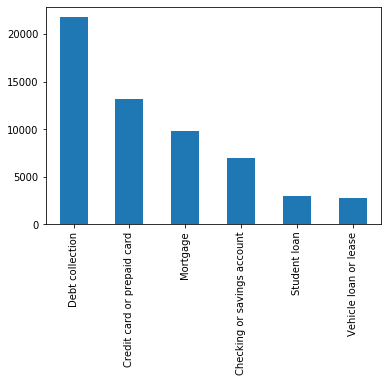

In [8]:
df['Product'].value_counts().plot(kind='bar')

In [9]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
Tormey Bewley Corporation                   1
YKS Acceptance, Inc.                        1
Jana Ferrell & Associates LLC               1
Century Debt Solutions Inc.                 1
Student Loan Care, LLC                      1
Name: Company, Length: 2197, dtype: int64

In [10]:
complaints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [11]:
target = {'Debt collection':0,'Credit card or prepaid card':1,'Mortgage':2,'Checking or savings account':3,'Student loan':4,'Vehicle loan or lease':5}

In [12]:
complaints_df['target']=complaints_df['Product'].map(target)

In [15]:
complaints_df

,complaints,Product,Company,target
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc.",0
...,...,...,...,...
57448,I am attempting to make a payment toward my st...,Student loan,"Nelnet, Inc.",4
57449,Received letter for {$480.00}. Original credit...,Debt collection,"The Receivable Management Services LLC, New Yo...",0
57450,entire time 10 years until XX/XX/2020. XXXX ma...,Debt collection,"Convergent Resources, Inc.",0
57451,I am a customer with Wells Fargo Bank. Recentl...,Checking or savings account,WELLS FARGO & COMPANY,3


In [34]:
X_train, X_test = train_test_split(complaints_df, test_size = 0.2, random_state = 111)

In [35]:
stemmer = nltk.stem.SnowballStemmer('english')

In [36]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Varun Vaibhav
[nltk_data]     Jha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word)>3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+','',word.strip('Xx/')))>3)]
    tokens = map(str.lower,tokens)
    stems = [stemmer.stem(item) for item in tokens if(item not in stop_words)]
    return stems

In [38]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize,stop_words = None, max_df=0.75, max_features=1000, lowercase = False, ngram_range = (1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complaints)

In [39]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05982061, 0.        , ..., 0.        , 0.        ,
        0.04799437],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09583077],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
vectorizer_tf.get_feature_names()

['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'access account',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'asset',
 'assign',

In [41]:
test_vectors = vectorizer_tf.transform(X_test.complaints)

In [42]:
X_train.shape

(45962, 4)

In [43]:
train_df=pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)
train_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,...,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012925,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
1,0.0,0.059821,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047994,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031234,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.127599,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
45958,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.103426,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,2
45959,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.059812,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.095831,1
45960,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1


In [44]:
test_df=pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)
test_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,...,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.086918,0.0,0.0,0.0,0.211913,0.0,0.0,0.348196,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.124611,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.146786,0.0,0.0,0.0,0.000000,0.0,0.0,0.220511,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.088463,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.045317,0.0,0.0,0.0,0.0,0.0,0.070974,4
4,0.0,0.079906,0.0,0.0,0.0,0.000000,0.0,0.0,0.040013,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.128219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.020535,0.0,...,0.0,0.129507,0.000000,0.0,0.0,0.0,0.0,0.0,0.032901,1
11487,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.183318,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4
11488,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.139306,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
11489,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.077802,0


In [45]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [46]:
h2o_train_df.types

{'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'access account': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow'

In [47]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [48]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble"],verbosity="info",nfolds=0,balance_classes=True,max_after_balance_size=0.3)

In [49]:
x = vectorizer_tf.get_feature_names()
y = 'target'

In [50]:
aml.train(x = x, y = y, training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |█
22:35:55.538: Project: AutoML_20201112_223555538
22:35:55.538: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:35:55.554: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
22:35:55.554: Build control seed: 10
22:35:55.554: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
22:35:57.408: training frame: Frame key: automl_training_py_1_sid_99be    cols: 1001    rows: 41256  chunks: 53    size: 34317884  checksum: -7250044210537209784
22:35:57.411: validation frame: Frame key: py_2_sid_99be    cols: 1001    rows: 11491  chunks: 14    size: 9650383  checksum: -3525458438983238450
22:35:57.452: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_99be    cols: 1001    rows: 4706  chunks: 53    size: 7551836  checksum: -6406089023458826254
22:35:57.452: blending frame: NULL
22:35:57.452: respon

In [51]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
GBM_5_AutoML_20201112_223555,0.144965,0.371045,0.321411,0.103305
GBM_2_AutoML_20201112_223555,0.151019,0.379765,0.333443,0.111184
GBM_4_AutoML_20201112_223555,0.15297,0.386429,0.334208,0.111695
GBM_grid__1_AutoML_20201112_223555_model_1,0.15505,0.406446,0.338355,0.114484
GBM_3_AutoML_20201112_223555,0.160114,0.394517,0.339311,0.115132
GBM_1_AutoML_20201112_223555,0.161033,0.404265,0.343577,0.118045
GLM_1_AutoML_20201112_223555,0.172819,0.380815,0.337484,0.113896
DeepLearning_1_AutoML_20201112_223555,0.179605,0.554205,0.369377,0.136439
XRT_1_AutoML_20201112_223555,0.273971,0.604417,0.448896,0.201508
DRF_1_AutoML_20201112_223555,0.282182,0.599123,0.44671,0.19955


In [52]:
pred=aml.leader.predict(h2o_test_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [54]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.10664093624678768
RMSE: 0.3265592384955411
LogLoss: 0.3787255832863651
Mean Per-Class Error: 0.15203211162433491

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3885.0,163.0,67.0,40.0,57.0,83.0,0.095460,"410 / 4,295"
1,191.0,2227.0,18.0,120.0,3.0,24.0,0.137824,"356 / 2,583"
2,74.0,35.0,1835.0,17.0,16.0,38.0,0.089330,"180 / 2,015"
3,53.0,123.0,18.0,1259.0,0.0,8.0,0.138261,"202 / 1,461"
4,47.0,18.0,14.0,3.0,506.0,23.0,0.171849,105 / 611
5,69.0,44.0,21.0,7.0,6.0,379.0,0.279468,147 / 526
6,4319.0,2610.0,1973.0,1446.0,588.0,555.0,0.121834,"1,400 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.878166
1,2,0.959272
2,3,0.983291
3,4,0.993125
4,5,0.997999
5,6,1.000000


In [57]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

['GBM_5_AutoML_20201112_223555',
 'GBM_2_AutoML_20201112_223555',
 'GBM_4_AutoML_20201112_223555',
 'GBM_grid__1_AutoML_20201112_223555_model_1',
 'GBM_3_AutoML_20201112_223555',
 'GBM_1_AutoML_20201112_223555',
 'GLM_1_AutoML_20201112_223555',
 'DeepLearning_1_AutoML_20201112_223555',
 'XRT_1_AutoML_20201112_223555',
 'DRF_1_AutoML_20201112_223555']

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
gbm_clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.05,max_depth=6,random_state=10)

In [63]:
gbm_clf.fit(train_vectors, X_train['target'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [64]:
predictions = gbm_clf.predict(test_vectors)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(X_test['target'],predictions)
print(cm)

[[3960  148   65   27   42   53]
 [ 248 2222   11   82    3   17]
 [  97   29 1825   25   12   27]
 [  84  133   19 1217    0    8]
 [  75   26   27    1  463   19]
 [ 116   43   26   10    5  326]]


In [67]:
print('Classification Report:\n',classification_report(X_test['target'],predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4295
           1       0.85      0.86      0.86      2583
           2       0.92      0.91      0.92      2015
           3       0.89      0.83      0.86      1461
           4       0.88      0.76      0.82       611
           5       0.72      0.62      0.67       526

    accuracy                           0.87     11491
   macro avg       0.86      0.82      0.84     11491
weighted avg       0.87      0.87      0.87     11491



In [68]:
from sklearn.utils import class_weight

In [69]:
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(X_train['target']),X_train['target']))

In [70]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [73]:
weights = np.ones(X_train.shape[0],dtype='float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [75]:
for i,val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [76]:
weights

array([1.38223265, 0.4383094 , 0.4383094 , ..., 0.72199183, 0.72199183,
       0.98411271])

In [77]:
gbm_clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.05,max_depth=6,random_state=10)

In [78]:
gbm_clf.fit(train_vectors, X_train['target'],sample_weight=weights)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [79]:
predictions = gbm_clf.predict(test_vectors)

In [80]:
cm = confusion_matrix(X_test['target'],predictions)
print(cm)

[[3713  181   86   75   77  163]
 [ 143 2143   21  152    4  120]
 [  39   15 1808   27   39   87]
 [  26  101   15 1293    4   22]
 [  25    7    5    2  518   54]
 [  47   17   12   12   14  424]]


In [81]:
print('Classification Report:\n',classification_report(X_test['target'],predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.90      4295
           1       0.87      0.83      0.85      2583
           2       0.93      0.90      0.91      2015
           3       0.83      0.89      0.86      1461
           4       0.79      0.85      0.82       611
           5       0.49      0.81      0.61       526

    accuracy                           0.86     11491
   macro avg       0.81      0.86      0.82     11491
weighted avg       0.88      0.86      0.87     11491



In [83]:
print("Accuracy score (test): {0:.3f}".format(gbm_clf.score(test_vectors, X_test['target'])))

Accuracy score (test): 0.861
